In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [72]:
df = pd.read_csv("SeoulBikeDataClean.csv")

# same as Poisson
formula = (
    'rented_bike_count ~ temperaturec + temperaturec_squared + '
    'is_raining + is_snowing + is_holiday + is_working_day + '
    'C(hour)'
)

# Fit NB regression
nb_model = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.NegativeBinomial()
).fit()

print(nb_model.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:      rented_bike_count   No. Observations:                 8760
Model:                            GLM   Df Residuals:                     8730
Model Family:        NegativeBinomial   Df Model:                           29
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63090.
Date:                Sun, 04 May 2025   Deviance:                       6147.7
Time:                        17:51:42   Pearson chi2:                 2.43e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.5096
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.4852 

c:\Users\dkkdk\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [73]:

print(f"\nDeviance / df: {nb_model.deviance:.2f} / {nb_model.df_resid} = {nb_model.deviance / nb_model.df_resid:.2f}")
print(f"Pearson Chi2 / df: {nb_model.pearson_chi2:.2f} / {nb_model.df_resid} = {nb_model.pearson_chi2 / nb_model.df_resid:.2f}")


Deviance / df: 6147.71 / 8730 = 0.70
Pearson Chi2 / df: 2426.47 / 8730 = 0.28


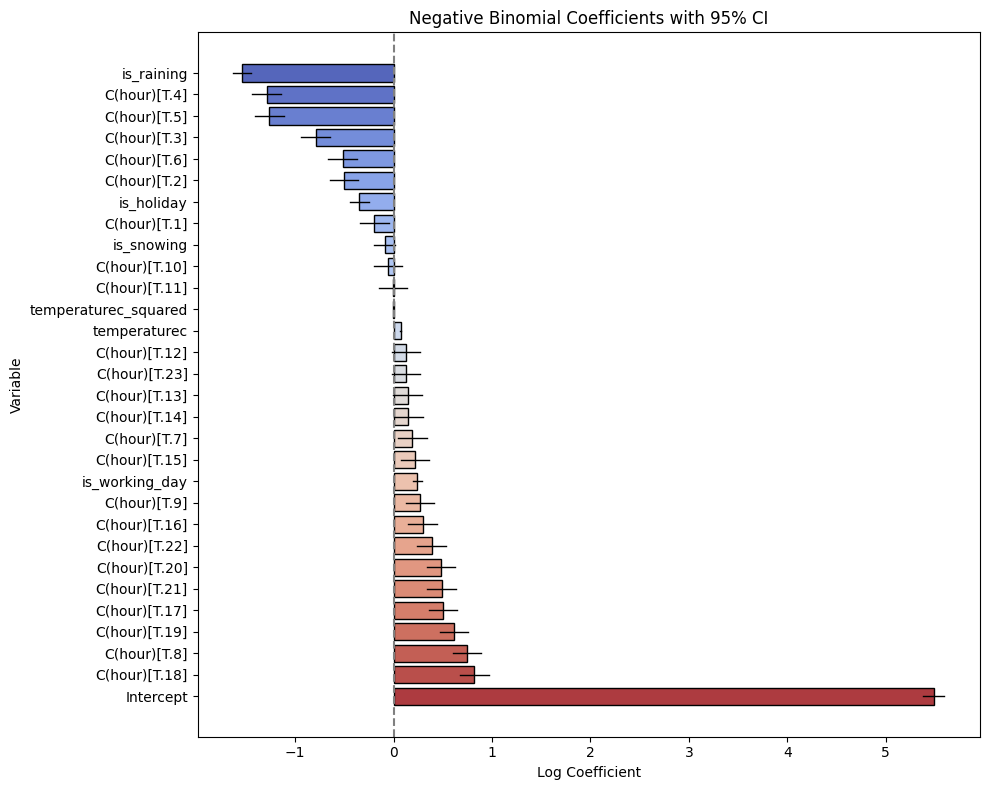

In [74]:
# Get model coefficients and confidence intervals
coef = nb_model.params
conf = nb_model.conf_int()
conf.columns = ['2.5%', '97.5%']
coef_df = pd.concat([coef, conf], axis=1)
coef_df.columns = ['coef', 'ci_lower', 'ci_upper']
coef_df['variable'] = coef_df.index

# Sort by coefficient magnitude
coef_df = coef_df.sort_values(by='coef')

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='coef', y='variable', data=coef_df,
            palette='coolwarm', orient='h', edgecolor='black')
# Add error bars
for i in range(coef_df.shape[0]):
    plt.plot([coef_df['ci_lower'].iloc[i], coef_df['ci_upper'].iloc[i]],
             [i, i], color='black', lw=1)

plt.axvline(x=0, color='gray', linestyle='--')
plt.title("Negative Binomial Coefficients with 95% CI")
plt.xlabel("Log Coefficient")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

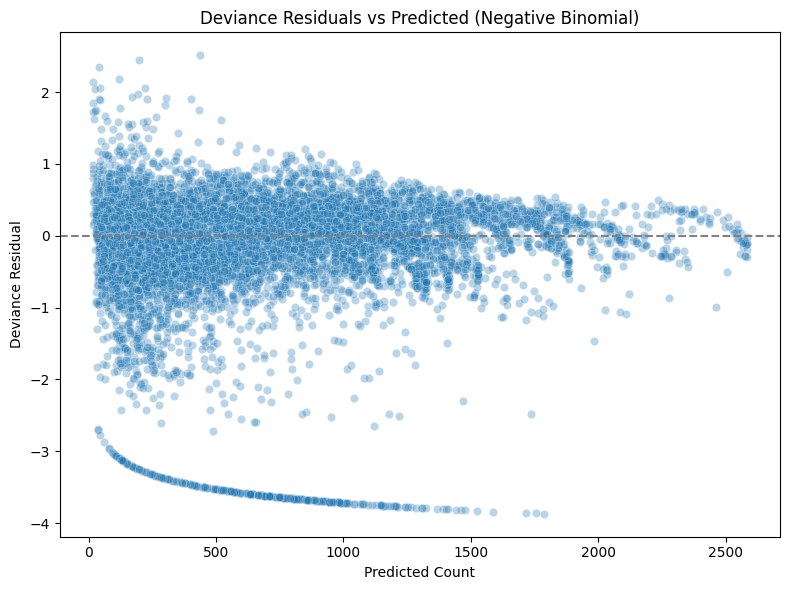

In [75]:
# Get predicted counts and deviance residuals
df['nb_pred'] = nb_model.predict()
df['nb_resid_deviance'] = nb_model.resid_deviance

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='nb_pred', y='nb_resid_deviance', data=df, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--')
plt.title("Deviance Residuals vs Predicted (Negative Binomial)")
plt.xlabel("Predicted Count")
plt.ylabel("Deviance Residual")
plt.tight_layout()
plt.show()

# train–val–test split

In [76]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# 1. Load cleaned dataset
df = pd.read_csv("SeoulBikeDataClean.csv")

# 2. Parse date
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y", errors="coerce")
df = df.dropna(subset=["date"])

# 3. Sort by date
df = df.sort_values("date")

# 4. Split based on date ranges
train_df = df[df["date"] < "2018-07-01"].copy()
val_df = df[(df["date"] >= "2018-07-01") & (df["date"] < "2018-10-01")].copy()
test_df = df[df["date"] >= "2018-10-01"].copy()

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")

# 5. Standardize temperature
mean_temp = train_df["temperaturec"].mean()
std_temp = train_df["temperaturec"].std()
for split_df in [train_df, val_df, test_df]:
    split_df["temp_std"] = (split_df["temperaturec"] - mean_temp) / std_temp
    split_df["temp_std_squared"] = split_df["temp_std"] ** 2

# 6. Fit Negative Binomial model
formula = (
    'rented_bike_count ~ temp_std + temp_std_squared + '
    'is_raining + is_snowing + is_holiday + is_working_day + '
    'C(hour)'
)
nb_model = smf.glm(formula=formula, data=train_df,
                   family=sm.families.NegativeBinomial()).fit()
print(nb_model.summary())

Train: (5088, 23), Val: (2208, 23), Test: (1464, 23)
                 Generalized Linear Model Regression Results                  
Dep. Variable:      rented_bike_count   No. Observations:                 5088
Model:                            GLM   Df Residuals:                     5058
Model Family:        NegativeBinomial   Df Model:                           29
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35260.
Date:                Sun, 04 May 2025   Deviance:                       1921.8
Time:                        17:51:42   Pearson chi2:                 1.11e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.5926
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

c:\Users\dkkdk\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



📊 Validation Set Metrics: {'RMSE': 1194.155590845359, 'MAE': 825.7643902868205, 'R²': -2.2200474784460966}
📊 Test Set Metrics: {'RMSE': 472.7963297821005, 'MAE': 364.81791487998294, 'R²': 0.3602743981401175}


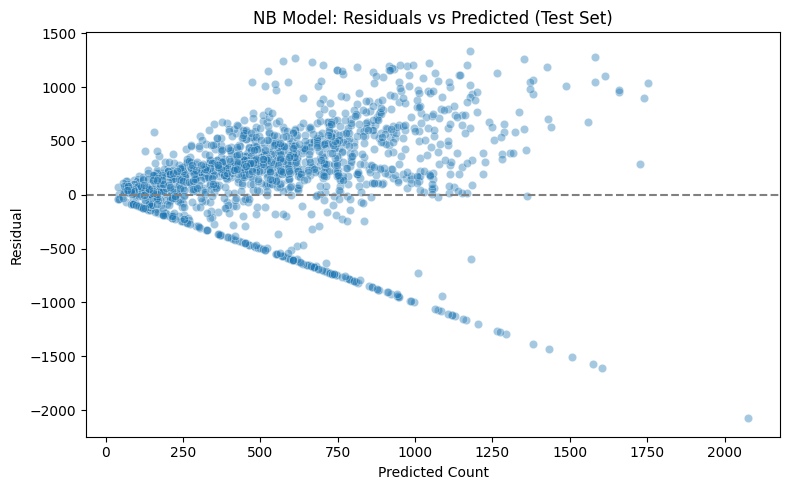

In [78]:
# 7. Predict
val_df["predicted_count"] = nb_model.predict(val_df)
test_df["predicted_count"] = nb_model.predict(test_df)

# 8. Evaluate
def evaluate(true, pred):
    return {
        "RMSE": mean_squared_error(true, pred, squared=False),
        "MAE": mean_absolute_error(true, pred),
        "R²": r2_score(true, pred)
    }

val_metrics = evaluate(val_df["rented_bike_count"], val_df["predicted_count"])
test_metrics = evaluate(test_df["rented_bike_count"], test_df["predicted_count"])

print("\n📊 Validation Set Metrics:", val_metrics)
print("📊 Test Set Metrics:", test_metrics)

# 9. Residual plot on test set
test_df["residual"] = test_df["rented_bike_count"] - test_df["predicted_count"]

plt.figure(figsize=(8, 5))
sns.scatterplot(x="predicted_count", y="residual", data=test_df, alpha=0.4)
plt.axhline(0, color="gray", linestyle="--")
plt.title("NB Model: Residuals vs Predicted (Test Set)")
plt.xlabel("Predicted Count")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

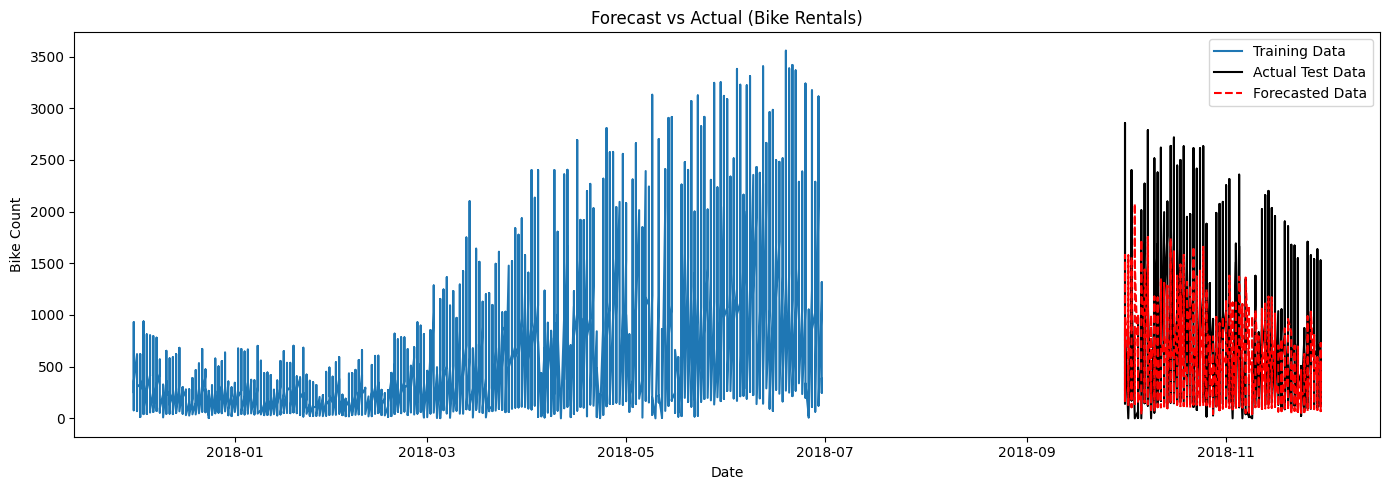

In [79]:
import matplotlib.pyplot as plt

# 拼接 train 和 test，画完整时序
plot_df = pd.concat([
    train_df[["date", "rented_bike_count"]],
    test_df[["date", "rented_bike_count"]]
]).sort_values("date")

# 准备预测值 (只画 test 的预测)
test_pred = test_df[["date", "predicted_count"]].copy()
test_pred = test_pred.sort_values("date")

plt.figure(figsize=(14, 5))

# 训练集实际值
plt.plot(train_df["date"], train_df["rented_bike_count"], label="Training Data", color="tab:blue")

# 测试集实际值
plt.plot(test_df["date"], test_df["rented_bike_count"], label="Actual Test Data", color="black")

# 测试集预测值
plt.plot(test_pred["date"], test_pred["predicted_count"], label="Forecasted Data", color="red", linestyle="--")

plt.title("Forecast vs Actual (Bike Rentals)")
plt.xlabel("Date")
plt.ylabel("Bike Count")
plt.legend()
plt.tight_layout()
plt.show()

